In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from dataclasses import dataclass

In [71]:
def plot_series(time, series, format="-", start=0, end=None):
  if type(series):
    for s in series:
      plt.plot(time, s)
  else:
    plt.plot(time, series) 
  plt.xlabel("Time") 
  plt.ylabel("Value")
  plt.show()

def trend(time, slope):
  return time*slope

def seasonal_pattern(season_time):
  return np.where(season_time<0.2,
                  np.cos(season_time*6*np.pi),
                  1/np.exp(season_time*3))
  
def seasonality(time, period, amplitude=1, phase=0):
  season_time = ((time+phase) % period) / period
  return seasonal_pattern(season_time)*amplitude

def noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

In [17]:
def generate_time_series():
  time = np.arange(365*4+1, dtype="float32")

  y_intercept = 10
  slope = 0.05
  series = trend(time, slope) + y_intercept

  amplitude = 50
  series += seasonality(time, period=365, amplitude=amplitude)
  series += noise(time, noise_level=3, seed=42)

  return time, series

In [18]:
@dataclass
class G:
  TIME, SERIES = generate_time_series()
  SPLIT_TIME = 1100
  WINDOW_SIZE=20
  BATCH_SIZE=32
  SHUFFLE_BUFFER_SIZE=1000

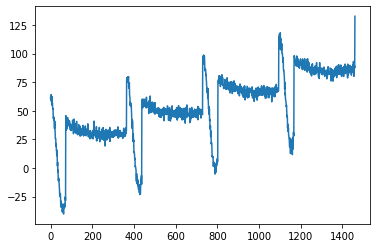

In [19]:
plt.plot(G.TIME, G.SERIES)
plt.show()

In [20]:
def train_val_split(time, series, split_time=G.SPLIT_TIME):
  x_train = series[:split_time]
  x_test = series[split_time:]
  train_time = time[:split_time]
  test_time = time[split_time:]

  return x_train, x_test, train_time, test_time

In [21]:
x_train, x_test, train_time, test_time = train_val_split(G.TIME, G.SERIES)

In [22]:
def windowed_data(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer_size=G.SHUFFLE_BUFFER_SIZE):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda w: w.batch(window_size+1))
  dataset = dataset.map(lambda w: (w[:-1], w[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [23]:
dataset = windowed_data(x_train)

In [32]:
def create_model():
  model = tf.keras.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[G.WINDOW_SIZE]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40)),
      tf.keras.layers.Dense(20),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x*100),
  ])
  return model

In [34]:
model = create_model()

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))

model.compile(optimizer=tf.keras.optimizers.SGD(), loss=tf.keras.losses.Huber(), metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_scheduler])

Epoch 1/100
34/34 [==============================] - 11s 41ms/step - loss: 14.5592 - mae: 15.0546 - lr: 1.0000e-08
Epoch 2/100
34/34 [==============================] - 1s 40ms/step - loss: 13.5680 - mae: 14.0635 - lr: 1.1220e-08
Epoch 3/100
34/34 [==============================] - 1s 39ms/step - loss: 12.7276 - mae: 13.2227 - lr: 1.2589e-08
Epoch 4/100
34/34 [==============================] - 1s 38ms/step - loss: 12.0269 - mae: 12.5201 - lr: 1.4125e-08
Epoch 5/100
34/34 [==============================] - 1s 35ms/step - loss: 11.4652 - mae: 11.9601 - lr: 1.5849e-08
Epoch 6/100
34/34 [==============================] - 1s 36ms/step - loss: 11.0226 - mae: 11.5155 - lr: 1.7783e-08
Epoch 7/100
34/34 [==============================] - 1s 40ms/step - loss: 10.6783 - mae: 11.1720 - lr: 1.9953e-08
Epoch 8/100
34/34 [==============================] - 1s 40ms/step - loss: 10.4234 - mae: 10.9138 - lr: 2.2387e-08
Epoch 9/100
34/34 [==============================] - 1s 35ms/step - loss: 10.2428 - mae

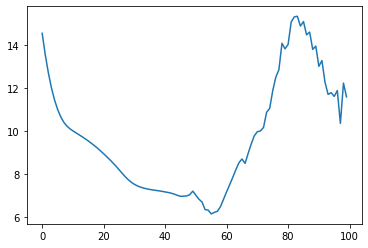

In [35]:
plt.plot(history.history["loss"])

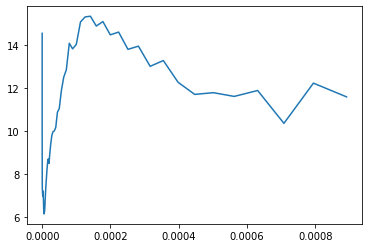

In [38]:
plt.plot(history.history["lr"], history.history["loss"])

In [39]:
np.argmin(history.history["loss"])

55

In [40]:
history.history["lr"][55]

5.6234135e-06

In [42]:
model2 = create_model()

model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate = 5.6234135e-06), loss=tf.keras.losses.Huber(), metrics=["mae"])
history = model2.fit(dataset, epochs=100)

Epoch 1/100
34/34 [==============================] - 10s 36ms/step - loss: 22.1211 - mae: 22.6085
Epoch 2/100
34/34 [==============================] - 1s 36ms/step - loss: 19.7702 - mae: 20.2526
Epoch 3/100
34/34 [==============================] - 1s 38ms/step - loss: 14.7259 - mae: 15.2076
Epoch 4/100
34/34 [==============================] - 1s 39ms/step - loss: 12.0969 - mae: 12.5796
Epoch 5/100
34/34 [==============================] - 1s 36ms/step - loss: 9.8445 - mae: 10.3158
Epoch 6/100
34/34 [==============================] - 1s 40ms/step - loss: 8.7834 - mae: 9.2524
Epoch 7/100
34/34 [==============================] - 1s 36ms/step - loss: 8.0001 - mae: 8.4686
Epoch 8/100
34/34 [==============================] - 3s 77ms/step - loss: 7.4010 - mae: 7.8672
Epoch 9/100
34/34 [==============================] - 2s 73ms/step - loss: 6.9708 - mae: 7.4394
Epoch 10/100
34/34 [==============================] - 1s 36ms/step - loss: 6.6402 - mae: 7.1084
Epoch 11/100
34/34 [===================

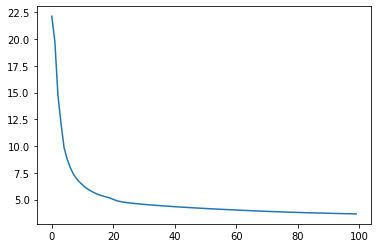

In [43]:
plt.plot(history.history["loss"])

In [48]:
def faster_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [50]:
f = faster_forecast(model2, G.SERIES, G.WINDOW_SIZE).squeeze()

ff = f[G.SPLIT_TIME - G.WINDOW_SIZE: -1]

46/46 [==============================] - 1s 24ms/step


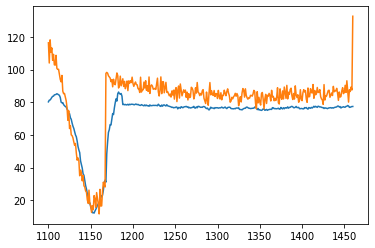

In [63]:
plt.plot(test_time, ff)
plt.plot(test_time, x_test)

In [75]:
tf.keras.metrics.mean_absolute_error(x_test, ff).numpy()

9.818341